### **Noiseless Comparison between VQE, QAOA, classical Eigensolver**

---

In [1]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# ============================
# STEP 1: MARKET DATA
# ============================

tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT"]

data = yf.download(tickers, start="2023-01-01", end="2024-01-01", progress=False)
data = data["Close"]

returns = data.pct_change().dropna()

mu = returns.mean() * 252
sigma = returns.cov() * 252

mu = mu.to_numpy()
sigma = sigma.to_numpy()

print("\n--- Real Data for QAOA ---")
print("Top 3 Expected Returns:", mu[:3])
print("Covariance Matrix Shape:", sigma.shape)



--- Real Data for QAOA ---
Top 3 Expected Returns: [0.46240171 0.63289659 0.50140754]
Covariance Matrix Shape: (10, 10)


In [2]:

# ============================
# STEP 2: BUILD QP MODEL
# ============================
from qiskit_optimization import QuadraticProgram


budget = 5
risk_factor = 0.5
num_assets = len(tickers)
penalty=10

qp = QuadraticProgram()

for i in range(num_assets):
    qp.binary_var(name=tickers[i])

qp.minimize(
    linear = -mu,
    quadratic = risk_factor * sigma
)

qp.linear_constraint(
    linear = {tickers[i]: 1 for i in range(num_assets)},
    sense  = "==",
    rhs    = budget,
    name   = "budget_constraint"
)



<LinearConstraint: AAPL + AMZN + GOOGL + JNJ + JPM + MSFT + NVDA + TS... == 5 'budget_constraint'>

In [3]:

# ============================
# STEP 3: QUBO CONVERSION
# ============================
from qiskit_optimization.converters import QuadraticProgramToQubo

converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)


In [4]:
# =======================================
# convert QUBO  ->  Ising Hamiltonian
# =======================================
from qiskit.quantum_info import SparsePauliOp

op, offset = qubo.to_ising()

op = SparsePauliOp(op.paulis, op.coeffs.real)


In [ ]:
# helper function for probability
# ===============================================

def get_probs(result, qp):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, \nvalue {:.4f}".format(selection, value))

    probs = {}
    for i, sample in enumerate(result.samples):
        bitstring = "".join(str(int(x)) for x in sample.x)
        
        prob = sample.probability
        probs[bitstring] = prob
    
    probs_10 = dict(sorted(probs.items(), key=lambda x: x[1], reverse=True)[:10])
    
    print("\n----------------- Top 10 result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    
    for k in probs_10:
        prob = probs_10[k]
        x = np.array([int(i) for i in list(reversed(k))])
        val = qp.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, prob))
    print("---------------------------------------------------")
    return probs_10


Optimal: selection [1. 1. 0. 0. 0. 1. 1. 1. 0. 0.], 
value -3.0511

----------------- Top 10 result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 1 0 0 0 1 1]	-3.0511		1.0000


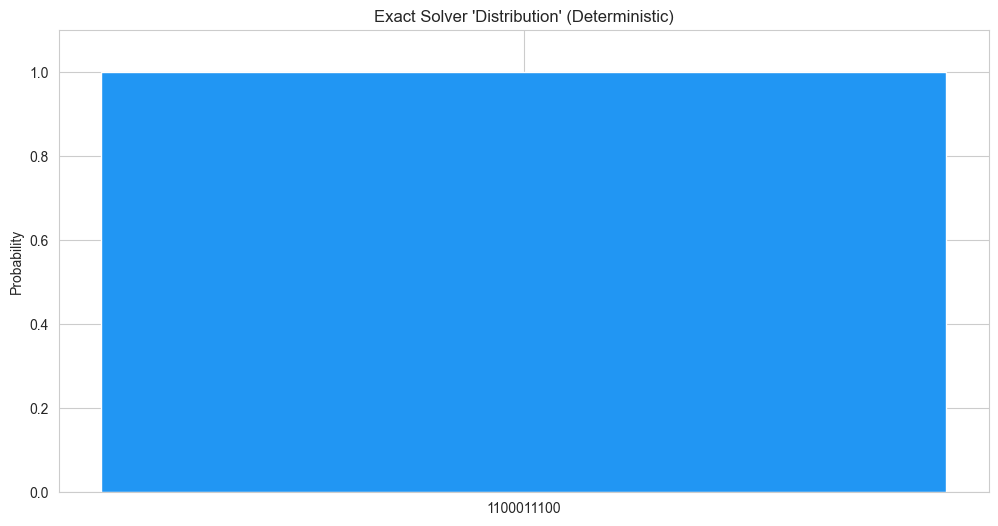

In [29]:
# ====================================================
# Exact solution using Numpy Minimum eigen solver
# ====================================================
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer


exact_mes = NumPyMinimumEigensolver()
exact_solver = MinimumEigenOptimizer(exact_mes)

exact_result = exact_solver.solve(qp)
exact_probs = get_probs(exact_result, qp)


plt.figure(figsize=(12, 6))
plt.bar(exact_probs.keys(), exact_probs.values(), color='#2196F3')
plt.title("Exact Solver 'Distribution' (Deterministic)")
plt.ylabel("Probability")
plt.ylim(0, 1.1)
plt.show()

Optimal: selection [1. 1. 1. 0. 0. 0. 1. 1. 0. 0.], 
value -3.0175


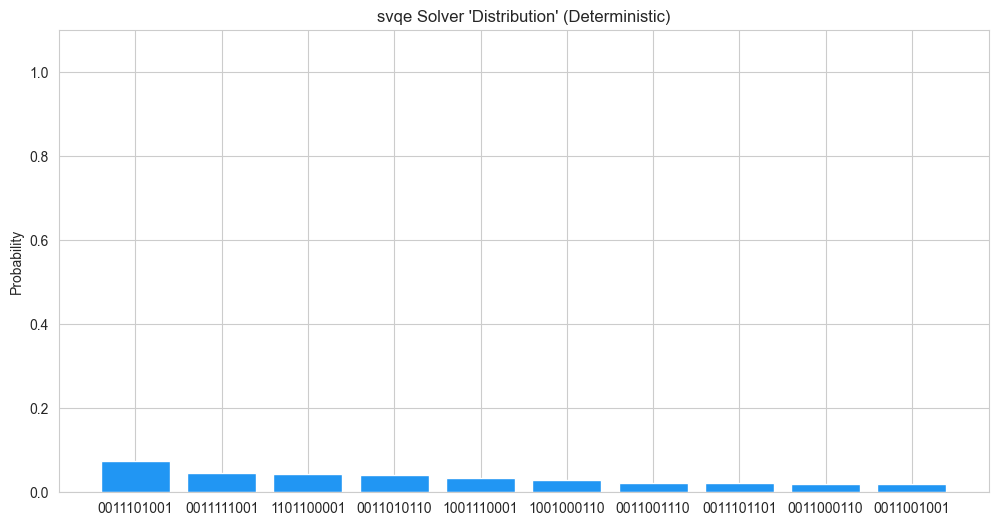

In [20]:

# ====================================================
# Using VQE
# ====================================================

import matplotlib.pyplot as plt
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# 1. define optimizer
cobyla = COBYLA(maxiter=100)

# 2. define ansatz
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")

# 3. setup VQE
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)

# 4. run optimizer
svqe = MinimumEigenOptimizer(svqe_mes)
svqe_result = svqe.solve(qp)

svqe_probs = get_probs(svqe_result)


plt.figure(figsize=(12, 6))
plt.bar(svqe_probs.keys(), svqe_probs.values(), color='#2196F3')
plt.title("svqe Solver 'Distribution' (Deterministic)")
plt.ylabel("Probability")
plt.ylim(0, 1.1)
plt.show()

Optimal: selection [1. 1. 0. 0. 0. 1. 1. 1. 0. 0.], 
value -3.0511


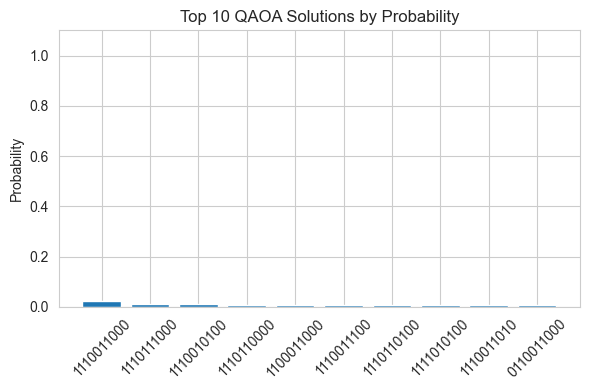

In [21]:
# ====================================================
# Using QAOA
# ====================================================
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.primitives import Sampler
from qiskit.quantum_info import SparsePauliOp


cobyla = COBYLA(maxiter=200)

qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)

qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(qp)

qaoa_probs = get_probs(qaoa_result)

plt.figure(figsize=(6, 4))
plt.bar(qaoa_probs.keys(), qaoa_probs.values())
plt.title("Top 10 QAOA Solutions by Probability")
plt.ylabel("Probability")
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

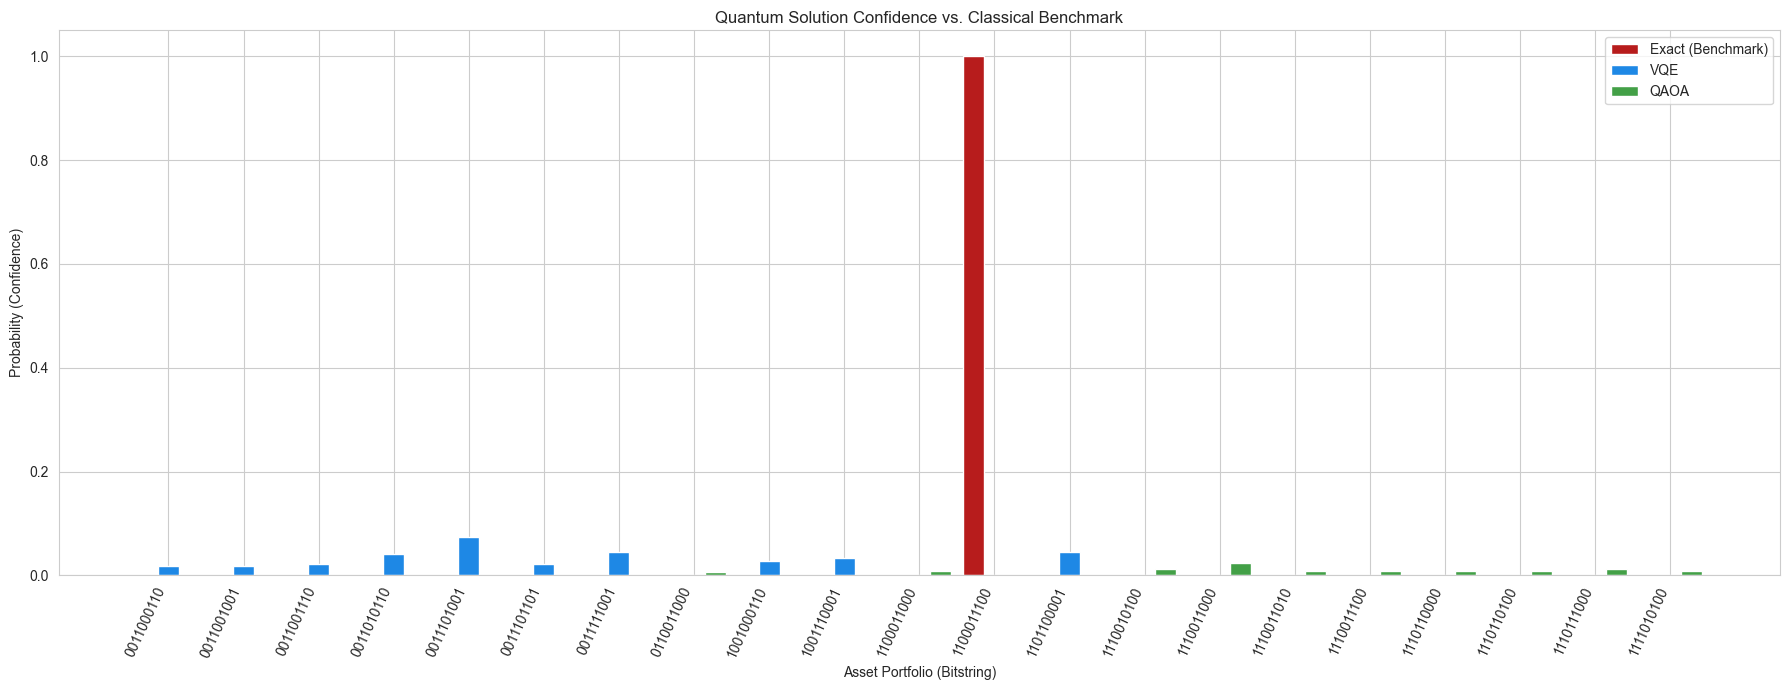

In [24]:

def plot_all_probabilities(exact_probs, vqe_probs, qaoa_probs):

    all_bitstrings = sorted(
        set(exact_probs.keys()) |
        set(vqe_probs.keys()) |
        set(qaoa_probs.keys())
    )

    # map bitstrings to probabilities (default = 0)
    exact_vals = [exact_probs.get(b, 0) for b in all_bitstrings]
    vqe_vals   = [vqe_probs.get(b, 0) for b in all_bitstrings]
    qaoa_vals  = [qaoa_probs.get(b, 0) for b in all_bitstrings]

    # x locations
    x = np.arange(len(all_bitstrings))
    width = 0.28

    plt.figure(figsize=(18, 7))

    # bars (shift each slightly)
    plt.bar(x - width, exact_vals, width=width, label="Exact (Benchmark)", color="#B71C1C")
    plt.bar(x,        vqe_vals,   width=width, label="VQE",               color="#1E88E5")
    plt.bar(x + width, qaoa_vals, width=width, label="QAOA",              color="#43A047")

    plt.xticks(x, all_bitstrings, rotation=65, ha="right")
    plt.ylabel("Probability (Confidence)")
    plt.xlabel("Asset Portfolio (Bitstring)")
    plt.title("Quantum Solution Confidence vs. Classical Benchmark")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_all_probabilities(exact_probs, svqe_probs, qaoa_probs)


In [9]:
import pandas as pd
import numpy as np

# 1. Gather Data
data = {
    "Method": ["Classical (Exact)", "Quantum (VQE)", "Quantum (QAOA)"],
    "Value (Cost)": [exact_result.fval, svqe_result.fval, qaoa_result.fval],
    "Selection": [exact_result.x, svqe_result.x, qaoa_result.x],
    "Asset Count": [sum(exact_result.x), sum(svqe_result.x), sum(qaoa_result.x)]
}

df = pd.DataFrame(data)

# 2. Calculate Accuracy (Gap to Optimal)
# How far off was the quantum energy from the classical energy?
optimal_val = exact_result.fval
df["Error Gap"] = df["Value (Cost)"] - optimal_val

# 3. Check for Identity (Did they pick the exact same portfolio?)
# We compare the binary arrays to the Exact solution
df["Success"] = df["Selection"].apply(lambda x: np.array_equal(x, exact_result.x))

# Print clean table
print("\n--- ALGORITHM COMPARISON ---")
print(df[["Method", "Value (Cost)", "Asset Count", "Success", "Error Gap"]])


--- ALGORITHM COMPARISON ---
              Method  Value (Cost)  Asset Count  Success  Error Gap
0  Classical (Exact)     -3.051054          5.0     True   0.000000
1      Quantum (VQE)     -2.678805          5.0    False   0.372249
2     Quantum (QAOA)     -3.051054          5.0     True   0.000000
